In [1]:
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from utils import *
from ipywidgets import interact

In [2]:
class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n
        self.count = n  # 初始时，每个元素都是一个独立的连通块

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)

        if root_x != root_y:
            if self.rank[root_x] < self.rank[root_y]:
                self.parent[root_x] = root_y
            elif self.rank[root_x] > self.rank[root_y]:
                self.parent[root_y] = root_x
            else:
                self.parent[root_y] = root_x
                self.rank[root_x] += 1

            self.count -= 1  # 每次合并连通块，连通块数量减少1

    def is_connected(self, x, y):
        return self.find(x) == self.find(y)

    def get_connected_components(self):
        components = []
        root_count = {}
        for i in range(len(self.parent)):
            root = self.find(i)
            if root not in root_count:
                root_count[root] = 0
            root_count[root] += 1

        for root, count in root_count.items():
            components.append(count)

        return components

    def get_num_connected_components(self):
        return self.count

Orientation image
""

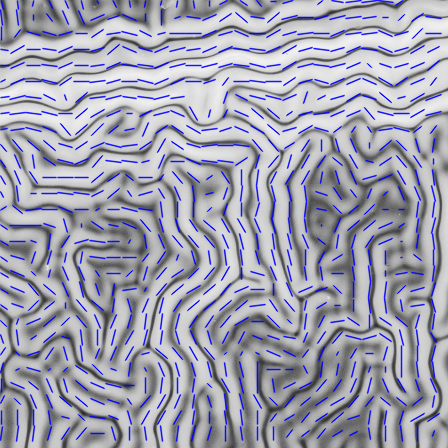

,
,

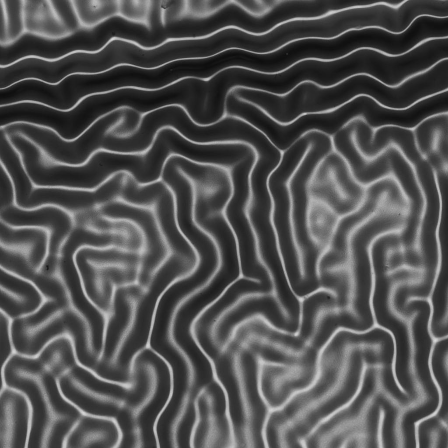
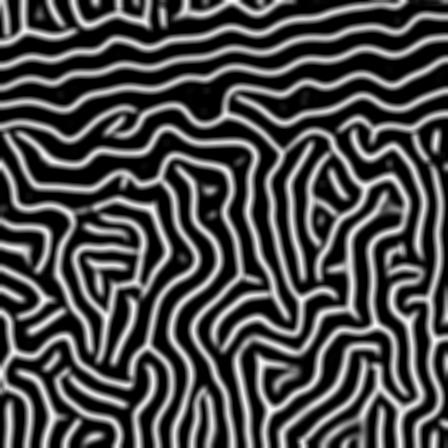

,,
,,

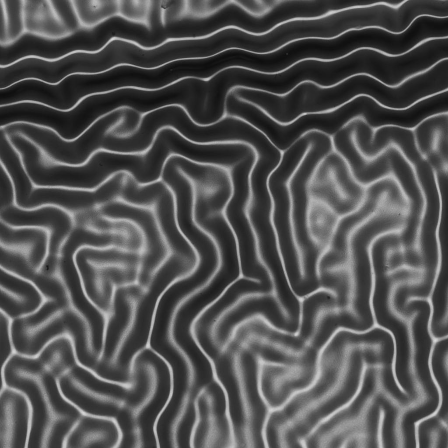
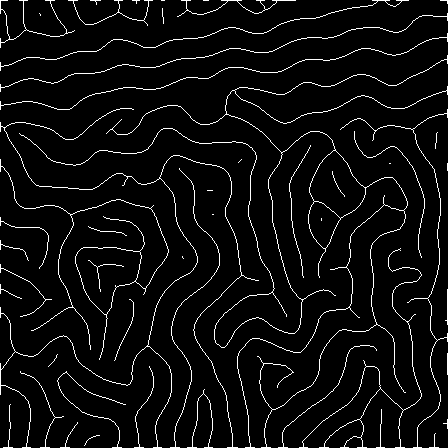
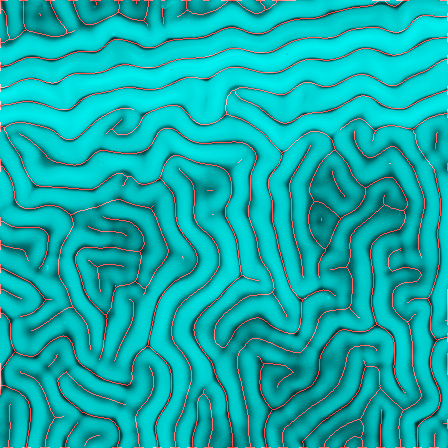

,,
,,

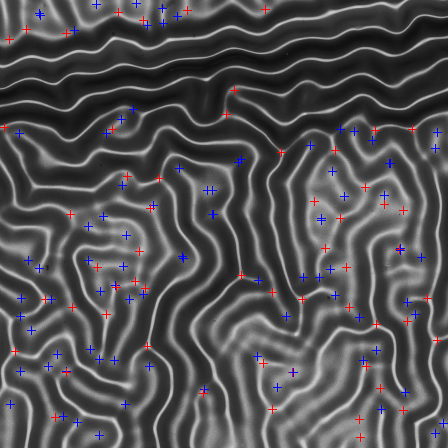
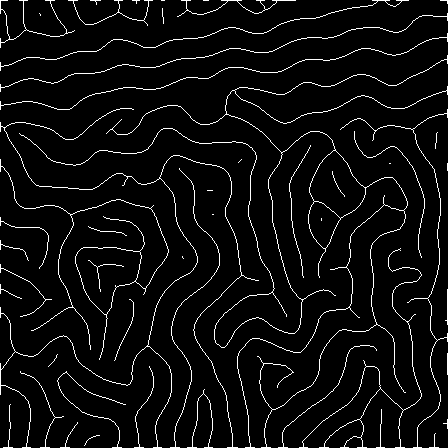
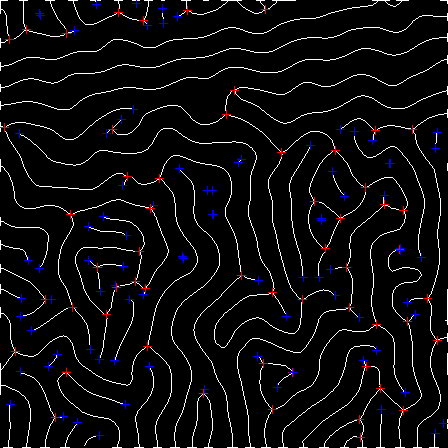

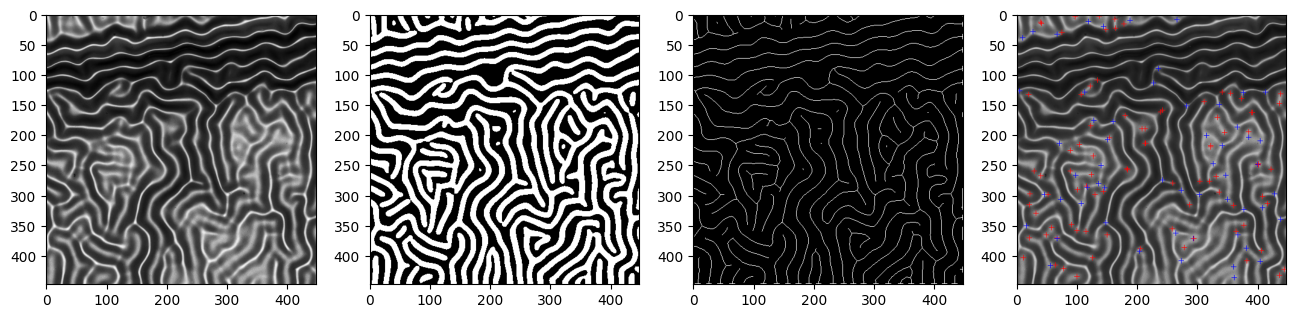

In [7]:
from scipy.interpolate import interp1d

def compute_crossing_number(values):
    return np.count_nonzero(values < np.roll(values, -1))


def smooth_skeleton(skeleton, num_points=10000):
    # 将骨架坐标转换为参数化的曲线形式
    skeleton_points = np.argwhere(skeleton == 255)
    x = skeleton_points[:, 1]
    y = skeleton_points[:, 0]
    t = np.arange(len(x))
    t_new = np.linspace(0, len(x)-1, num_points)

    # 使用线性插值进行平滑
    interp_func = interp1d(t, np.column_stack((x, y)), kind='linear', axis=0)
    smoothed_skeleton = interp_func(t_new)
    
    x_smooth_mapped = np.round(smoothed_skeleton[:, 0]).astype(int)
    y_smooth_mapped = np.round(smoothed_skeleton[:, 1]).astype(int)
    smoothed_image = np.zeros_like(skeleton)
    smoothed_image[y_smooth_mapped, x_smooth_mapped] = 255

    return smoothed_image


def process(show_fingerprint, fingerprint, visual=False):
    # Calculate the local gradient (using Sobel filters)
    gx, gy = cv.Sobel(fingerprint, cv.CV_32F, 1, 0), cv.Sobel(fingerprint, cv.CV_32F, 0, 1)

    # Calculate the magnitude of the gradient for each pixel
    gx2, gy2 = gx**2, gy**2
    gm = np.sqrt(gx2 + gy2)

    # Integral over a square window
    sum_gm = cv.boxFilter(gm, -1, (25, 25), normalize = False)

    # Use a simple threshold for segmenting the fingerprint pattern
    thr = sum_gm.max() * 0.2
    mask = cv.threshold(sum_gm, thr, 255, cv.THRESH_BINARY)[1].astype(np.uint8)

    W = (11, 11)
    gxx = cv.boxFilter(gx2, -1, W, normalize = False)
    gyy = cv.boxFilter(gy2, -1, W, normalize = False)
    gxy = cv.boxFilter(gx * gy, -1, W, normalize = False)
    gxx_gyy = gxx - gyy
    gxy2 = 2 * gxy

    orientations = (cv.phase(gxx_gyy, -gxy2) + np.pi) / 2 # '-' to adjust for y axis direction
    sum_gxx_gyy = gxx + gyy
    strengths = np.divide(cv.sqrt((gxx_gyy**2 + gxy2**2)), sum_gxx_gyy, out=np.zeros_like(gxx), where=sum_gxx_gyy!=0)
    if visual:
        show(draw_orientations(fingerprint, orientations, strengths, mask, 1, 16), 'Orientation image')

    region = fingerprint[10:90,80:130]
    # before computing the x-signature, the region is smoothed to reduce noise
    smoothed = cv.blur(region, (5,5), -1)
    xs = np.sum(smoothed, 1) # the x-signature of the region

    # Find the indices of the x-signature local maxima
    local_maxima = np.nonzero(np.r_[False, xs[1:] > xs[:-1]] & np.r_[xs[:-1] >= xs[1:], False])[0]

    # Calculate all the distances between consecutive peaks
    distances = local_maxima[1:] - local_maxima[:-1]

    # Estimate the ridge line period as the average of the above distances
    ridge_period = np.average(distances)
    if np.isnan(ridge_period):
        ridge_period = 20

    # Create the filter bank
    or_count = 32
    gabor_bank = [gabor_kernel(ridge_period, o) for o in np.arange(0, np.pi, np.pi/or_count)]

    # Filter the whole image with each filter
    # Note that the negative image is actually used, to have white ridges on a black background as a result
    nf = 255-fingerprint
    all_filtered = np.array([cv.filter2D(nf, cv.CV_32F, f) for f in gabor_bank])

    y_coords, x_coords = np.indices(fingerprint.shape)
    # For each pixel, find the index of the closest orientation in the gabor bank
    orientation_idx = np.round(((orientations % np.pi) / np.pi) * or_count).astype(np.int32) % or_count
    # Take the corresponding convolution result for each pixel, to assemble the final result
    filtered = all_filtered[orientation_idx, y_coords, x_coords]
    # Convert to gray scale and apply the mask
    enhanced = mask & np.clip(filtered, 0, 255).astype(np.uint8)
    enhanced = cv.blur(enhanced, (7, 7))
    if visual:
        show(show_fingerprint, enhanced)

    # Binarization
    _, ridge_lines = cv.threshold(enhanced, 64, 255, cv.THRESH_BINARY)

    # Thinning
    skeleton = cv.ximgproc.thinning(ridge_lines, thinningType = cv.ximgproc.THINNING_GUOHALL)
    if visual:
        show(show_fingerprint, skeleton, cv.merge((fingerprint, fingerprint, skeleton)))

    # Create a filter that converts any 8-neighborhood into the corresponding byte value [0,255]
    cn_filter = np.array([[  1,  2,  4],
                          [128,  0,  8],
                          [ 64, 32, 16]
                         ])

    # Create a lookup table that maps each byte value to the corresponding crossing number
    all_8_neighborhoods = [np.array([int(d) for d in f'{x:08b}'])[::-1] for x in range(256)]
    cn_lut = np.array([compute_crossing_number(x) for x in all_8_neighborhoods]).astype(np.uint8)

    # Skeleton: from 0/255 to 0/1 values
    skeleton01 = np.where(skeleton!=0, 1, 0).astype(np.uint8)
    # Apply the filter to encode the 8-neighborhood of each pixel into a byte [0,255]
    cn_values = cv.filter2D(skeleton01, -1, cn_filter, borderType = cv.BORDER_CONSTANT)
    # Apply the lookup table to obtain the crossing number of each pixel
    cn = cv.LUT(cn_values, cn_lut)
    # Keep only crossing numbers on the skeleton
    cn[skeleton==0] = 0

    # crossing number == 1 --> Termination, crossing number == 3 --> Bifurcation
    minutiae = [(x,y,cn[y,x]==1) for y, x in zip(*np.where(np.isin(cn, [1,3])))]

    # A 1-pixel background border is added to the mask before computing the distance transform
    mask_distance = cv.distanceTransform(cv.copyMakeBorder(mask, 1, 1, 1, 1, cv.BORDER_CONSTANT), cv.DIST_C, 3)[1:-1,1:-1]

    filtered_minutiae = list(filter(lambda m: mask_distance[m[1], m[0]]>3, minutiae))
    
    if visual:
        show(draw_minutiae(show_fingerprint, filtered_minutiae), skeleton, draw_minutiae(skeleton, filtered_minutiae))
    
    t = 8
    grid = np.sum(np.sum(ridge_lines.reshape(ridge_lines.shape[0] // t, t, ridge_lines.shape[1] // t, t), axis=3), axis=1)
    grid = grid / (t * t * 255)
    grid = grid > 0.5
        
    return ridge_lines, skeleton, filtered_minutiae, grid


# fingerprint = cv.imread('dataset/FDIF/new0/7.jpg', cv.IMREAD_GRAYSCALE)
fingerprint = cv.imread('dataset/dataset_v2/train/01216.jpg', cv.IMREAD_GRAYSCALE)
# fingerprint = cv.imread('dataset/dataset_v1/train2/15.jpg', cv.IMREAD_GRAYSCALE)
fingerprint = cv.resize(fingerprint, (448, 448))
# blur_fingerprint = cv.blur(fingerprint, (3, 3))
blur_fingerprint = fingerprint
blur_fingerprint = 255 - blur_fingerprint
ridge_lines, skeleton, filtered_minutiae, grid = process(fingerprint, blur_fingerprint, visual=True)

plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(fingerprint, cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(ridge_lines, cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(skeleton, cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(draw_minutiae(fingerprint, filtered_minutiae))
plt.show()
plt.close()

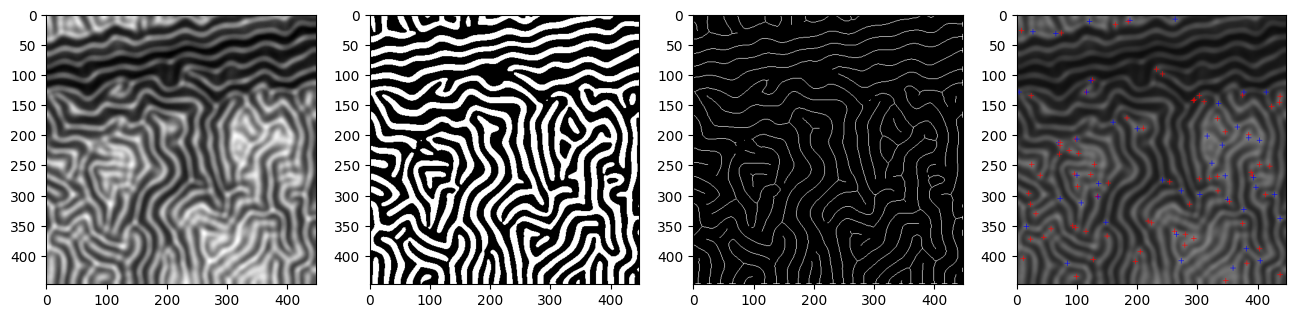

In [52]:
from PIL import Image

import torch
import torchvision.transforms as T

im = Image.open('dataset/dataset_v2/train/01216.jpg')
transforms = T.Compose([
    T.Resize((224, 224)),
    T.Grayscale(),
    T.RandomApply([T.ColorJitter(brightness=.4, contrast=.4, saturation=.2)], p=0.5),
    T.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 5))
])
im = transforms(im)

opencv_im = np.array(im)
fingerprint = cv.resize(opencv_im, (448, 448))
blur_fingerprint = fingerprint
blur_fingerprint = 255 - blur_fingerprint
ridge_lines, skeleton, filtered_minutiae, grid = process(fingerprint, blur_fingerprint, visual=False)

plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(fingerprint, cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(ridge_lines, cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(skeleton, cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(draw_minutiae(fingerprint, filtered_minutiae))
plt.show()
plt.close()

torch.Size([3, 224, 224])


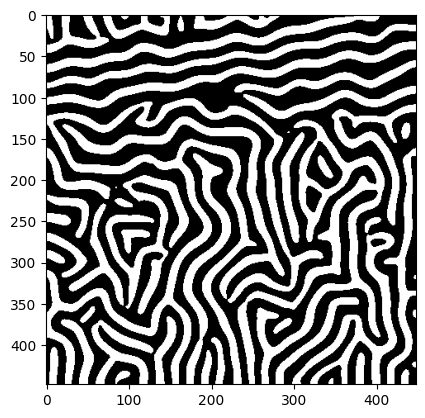

In [58]:
color_norm = T.Compose([
    T.Resize((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

im = torch.tensor(ridge_lines / 255.0)
im = im.reshape(im.shape[0], im.shape[1], 1).repeat(1, 1, 3).permute(2, 0, 1)
plt.imshow(im.permute(1, 2, 0))
im = color_norm(im)
print(im.shape)

In [198]:
import os
import datetime

data_dir = "dataset/dataset_v2/train/"
img_dic = {}
for root, dirs, files in os.walk(data_dir):
    for i, file in enumerate(files):
        if i % 100 == 0:
            print("{} / {} {}".format(i, len(files), datetime.datetime.now()))
        if file[-3:] == "jpg":
            img_pth = os.path.join(root, file)
            fingerprint = cv.imread(img_pth, cv.IMREAD_GRAYSCALE)
            fingerprint = 255 - cv.resize(fingerprint, (448, 448))
            ridge_lines, skeleton, filtered_minutiae, grid = process(fingerprint, fingerprint, visual=False)
            img_dic[img_pth] = {
                "ridge_lines": ridge_lines,
                "skeleton": skeleton,
                "filtered_minutiae": filtered_minutiae,
                "grid": grid
            }

0 / 11190 2023-06-14 13:45:30.252337
100 / 11190 2023-06-14 13:45:43.564011
200 / 11190 2023-06-14 13:45:56.956174
300 / 11190 2023-06-14 13:46:10.561482
400 / 11190 2023-06-14 13:46:23.744753
500 / 11190 2023-06-14 13:46:36.966792
600 / 11190 2023-06-14 13:46:50.169623
700 / 11190 2023-06-14 13:47:03.571090
800 / 11190 2023-06-14 13:47:17.048884
900 / 11190 2023-06-14 13:47:31.201129
1000 / 11190 2023-06-14 13:47:44.793889
1100 / 11190 2023-06-14 13:47:58.137755
1200 / 11190 2023-06-14 13:48:11.526247
1300 / 11190 2023-06-14 13:48:24.986128
1400 / 11190 2023-06-14 13:48:38.771214
1500 / 11190 2023-06-14 13:48:52.264457
1600 / 11190 2023-06-14 13:49:05.695617
1700 / 11190 2023-06-14 13:49:19.041880
1800 / 11190 2023-06-14 13:49:32.209582
1900 / 11190 2023-06-14 13:49:45.428890
2000 / 11190 2023-06-14 13:49:58.853730
2100 / 11190 2023-06-14 13:50:12.643382
2200 / 11190 2023-06-14 13:50:26.382716
2300 / 11190 2023-06-14 13:50:39.902556
2400 / 11190 2023-06-14 13:50:53.442518
2500 / 11190

11190


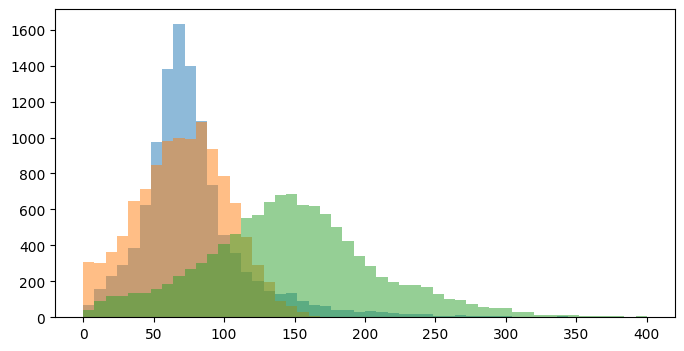

In [205]:
cnt1_list = []
cnt2_list = []
cnt3_list = []
print(len(img_dic.keys()))
for im_pth in img_dic.keys():
    filtered_minutiae = img_dic[im_pth]["filtered_minutiae"]
    cnt1 = 0
    cnt2 = 0
    for m in filtered_minutiae:
        if m[2]:
            cnt1 += 1
        else:
            cnt2 += 1
    cnt1_list.append(cnt1)
    cnt2_list.append(cnt2)
    cnt3_list.append(cnt1 + cnt2)
    
plt.figure(figsize=(8, 4))
plt.hist(cnt1_list, bins=50, range=(0, 400), alpha=0.5)
plt.hist(cnt2_list, bins=50, range=(0, 400), alpha=0.5)
plt.hist(cnt3_list, bins=50, range=(0, 400), alpha=0.5)
plt.show()
plt.close()